In [2]:
import numpy as np
import os
import dv_processing as dv
from datetime import timedelta
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import cv2


import sys
sys.path.append('../')
from src.data.preprocessing import *
from src.data.custom_dataset import *
from src.models.convlstm import ConvLSTM
from src.models.convsnn import ConvSNN
from src.models.spiking_convlstm import SpikingConvLSTM

from src.utils.plotting import *


In [2]:
train_dataloader, test_dataloader = create_dataloader(
    data_dir='../data/seq_data_acc',
    batch_size=64,
    num_workers=47,
)

Total number of sequences: 555
Number of training sequences: 444
Number of test sequences: 111


/home/khoahd/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Training set - Press: 32613, No Press: 100587
Test set - Press: 8574, No Press: 24726
Training DataLoader:
torch.Size([64, 300, 1, 32, 32]) torch.Size([64, 300])
Test DataLoader:
torch.Size([64, 300, 1, 32, 32]) torch.Size([64, 300])
Number of training batches: 7
Number of test batches: 2


## 1. ConvLSTM

In [4]:
checkpoint_path = '../saved_models/convlstm_accumulator/epoch=49-step=350.ckpt'
model = ConvLSTM.load_from_checkpoint(checkpoint_path, in_channels=1, feature_size=256)

[(16, 261), (0, 200), (12, 139), (24, 129), (11, 80), (13, 75), (96, 73), (22, 70), (75, 68), (78, 66), (74, 51), (18, 50), (89, 50), (83, 47), (53, 44), (38, 43), (62, 37), (46, 35), (68, 33), (42, 32), (90, 31), (100, 29), (39, 28), (103, 27), (69, 24), (45, 17), (59, 17), (33, 16), (48, 14), (60, 13), (86, 13), (55, 12), (5, 11), (30, 11), (36, 11), (93, 9), (6, 8), (3, 7), (20, 7), (32, 7), (84, 6), (29, 5), (72, 5), (85, 5), (107, 5), (37, 4), (73, 4), (82, 4), (1, 3), (4, 3), (43, 3), (104, 3), (109, 3), (23, 2), (34, 2), (77, 2), (92, 2), (28, 1), (41, 1), (64, 1), (108, 1), (2, 0), (7, 0), (8, 0), (9, 0), (10, 0), (14, 0), (15, 0), (17, 0), (19, 0), (21, 0), (25, 0), (26, 0), (27, 0), (31, 0), (35, 0), (40, 0), (44, 0), (47, 0), (49, 0), (50, 0), (51, 0), (52, 0), (54, 0), (56, 0), (57, 0), (58, 0), (61, 0), (63, 0), (65, 0), (66, 0), (67, 0), (70, 0), (71, 0), (76, 0), (79, 0), (80, 0), (81, 0), (87, 0), (88, 0), (91, 0), (94, 0), (95, 0), (97, 0), (98, 0), (99, 0), (101, 0), 

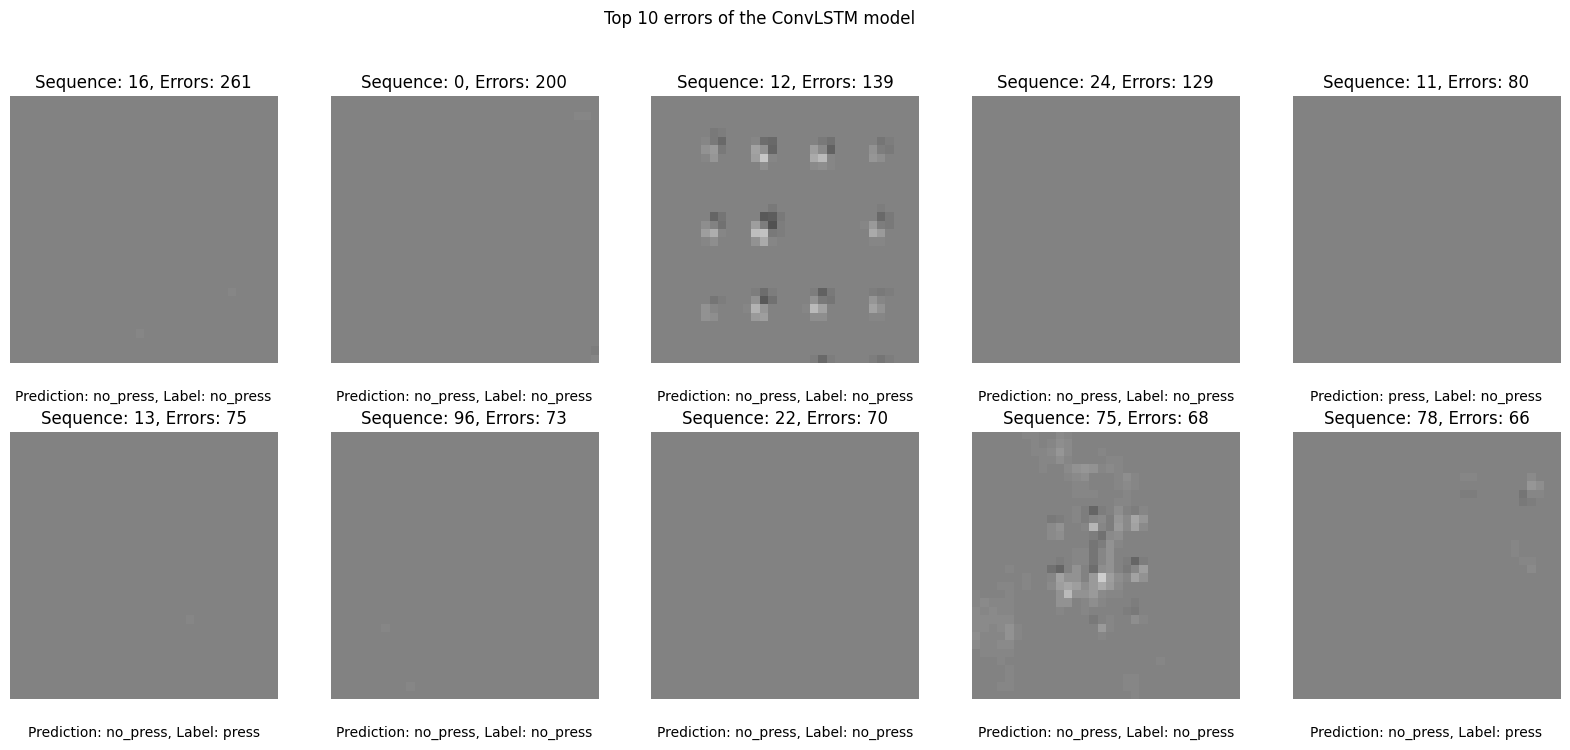

In [5]:
visualize_top_errors(model, test_dataloader, model_name="ConvLSTM", top_n=10, save_path='convlstm_top_errors.mp4')

## Spiking ConvLSTM

In [52]:
spiking_model = SpikingConvLSTM(beta_init=0.9, feature_size=64, spikegrad="fast_sigmoid", in_channels=1)

spiking_model.conv1.weight = model.cnn.conv_block_1[0].weight
spiking_model.conv1.bias = model.cnn.conv_block_1[0].bias

spiking_model.conv2.weight = model.cnn.conv_block_2[0].weight
spiking_model.conv2.bias = model.cnn.conv_block_2[0].bias

spiking_model.slstm.lstm_cell._parameters['weight_ih'] = model.lstm._parameters['weight_ih_l0']
spiking_model.slstm.lstm_cell._parameters['weight_hh'] = model.lstm._parameters['weight_hh_l0']

spiking_model.slstm.lstm_cell._parameters['bias_ih'] = model.lstm._parameters['bias_ih_l0']
spiking_model.slstm.lstm_cell._parameters['bias_hh'] = model.lstm._parameters['bias_hh_l0']


In [49]:
spiking_model.slstm.lstm_cell._parameters['weight_ih'] = model.lstm._parameters['weight_ih_l0']
spiking_model.slstm.lstm_cell._parameters['weight_hh'] = model.lstm._parameters['weight_hh_l0']

spiking_model.slstm.lstm_cell._parameters['bias_ih'] = model.lstm._parameters['bias_ih_l0']
spiking_model.slstm.lstm_cell._parameters['bias_hh'] = model.lstm._parameters['bias_hh_l0']

torch.nn.parameter.Parameter

In [37]:
spiking_model.conv1.bias


Parameter containing:
tensor([ 0.1577, -0.0461, -0.0613,  0.0092,  0.0830, -0.1278],
       requires_grad=True)

In [50]:
model.lstm._parameters['weight_ih_l0']

Parameter containing:
tensor([[ 0.1390, -0.0353, -0.0415,  ..., -0.0828,  0.0327,  0.0670],
        [ 0.0427, -0.0995,  0.0851,  ...,  0.0002, -0.0246,  0.0752],
        [ 0.0574, -0.0263, -0.0512,  ...,  0.0314, -0.0014, -0.0009],
        ...,
        [-0.0124, -0.0165,  0.0848,  ..., -0.1030, -0.0537,  0.0667],
        [ 0.1017,  0.0469, -0.0597,  ..., -0.0440, -0.0618,  0.1148],
        [ 0.0316,  0.0556, -0.1018,  ...,  0.0824, -0.0672,  0.0598]],
       device='cuda:0', requires_grad=True)

In [24]:
checkpoint_path = '../saved_models/convslstm_accumulator2/epoch=49-step=350.ckpt'
model = SpikingConvLSTM.load_from_checkpoint(checkpoint_path, beta_init=0.9, in_channels=1, spikegrad="fast_sigmoid", lr=0.001, feature_size=64)

: 

[(16, 261), (92, 217), (96, 163), (83, 161), (22, 146), (69, 146), (0, 139), (53, 136), (12, 123), (89, 123), (59, 120), (33, 112), (11, 106), (64, 106), (77, 98), (24, 96), (13, 95), (46, 79), (18, 74), (78, 72), (36, 67), (49, 57), (74, 57), (38, 56), (23, 55), (30, 51), (93, 48), (62, 46), (1, 43), (60, 39), (68, 39), (90, 37), (42, 36), (103, 35), (3, 34), (72, 34), (100, 34), (107, 28), (37, 24), (45, 23), (73, 22), (85, 21), (43, 19), (82, 19), (6, 18), (86, 18), (5, 14), (55, 14), (75, 14), (32, 13), (104, 13), (29, 12), (20, 11), (34, 11), (4, 10), (84, 10), (108, 10), (48, 9), (109, 9), (110, 8), (28, 6), (39, 6), (97, 6), (2, 5), (41, 5), (70, 3), (7, 0), (8, 0), (9, 0), (10, 0), (14, 0), (15, 0), (17, 0), (19, 0), (21, 0), (25, 0), (26, 0), (27, 0), (31, 0), (35, 0), (40, 0), (44, 0), (47, 0), (50, 0), (51, 0), (52, 0), (54, 0), (56, 0), (57, 0), (58, 0), (61, 0), (63, 0), (65, 0), (66, 0), (67, 0), (71, 0), (76, 0), (79, 0), (80, 0), (81, 0), (87, 0), (88, 0), (91, 0), (94,

KeyboardInterrupt: 

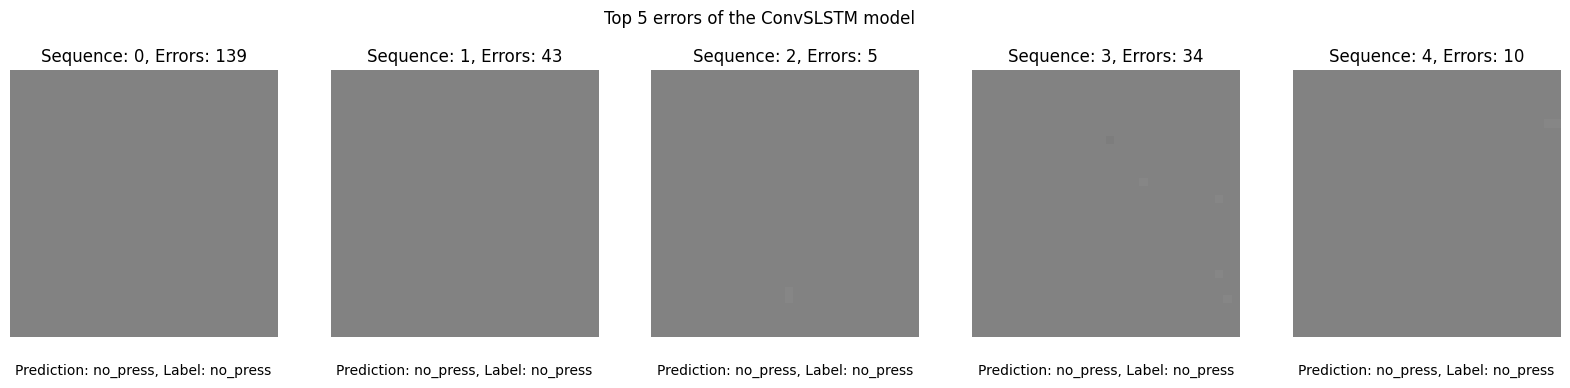

In [26]:
visualize_top_errors(model, test_dataloader, model_name="ConvSLSTM", top_n=5, save_path='convslstm_top_errors2.mp4')

## 2. ConvSNN

In [1]:
checkpoint_path = '/home/khoahd/Visual-Tactile-Sensing-with-Event-Cameras-using-Spiking-Neural-Networks/outputs/lightning_logs/version_0/checkpoints/epoch=19-step=280.ckpt'
model = ConvSNN.load_from_checkpoint(checkpoint_path, beta_init=0.9, in_channels=1, spikegrad="fast_sigmoid", lr=0.01)

NameError: name 'ConvSNN' is not defined

In [19]:
checkpoint_path = '/home/khoahd/Visual-Tactile-Sensing-with-Event-Cameras-using-Spiking-Neural-Networks/outputs/lightning_logs/version_11/checkpoints/epoch=19-step=280.ckpt'
model2 = SpikingConvLSTM.load_from_checkpoint(checkpoint_path, beta_init=0.9, in_channels=1, spikegrad="fast_sigmoid", lr=0.001, feature_size=64)

In [22]:
def visualize_top_errors(model, test_dataloader, model_name, top_n=5, save_path='top_errors.mp4'):    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    errors = []  # list of (sequence index, error_count_of_each_sequence)

    with torch.no_grad():
        batch_count = 0
        for sequence, target in test_dataloader:
            sequence = sequence.to(device)
            target = target.to(device) # (batch_size, sequence_length)
            output = model(sequence)  # (batch_size, sequence_length, 2)

            for i in range(sequence.size(0)):
                error_count = (output[i].argmax(dim=-1) != target[i]).sum().item()
                errors.append((batch_count * test_dataloader.batch_size + i, error_count))

            batch_count += 1

    top_errors = sorted(errors, key=lambda x: x[1], reverse=True)

    top_errors = [(59, 82), (39, 64)] 
    top_n = 2

    print(top_errors)


    print(sorted(errors, key=lambda x: x[1], reverse=True))
    sequences = []
    targets = []
    outputs = []
    class_to_idx = {0: 'no_press', 1: 'press'}

    for i in range(top_n):
        sequence, target = test_dataloader.dataset[top_errors[i][0]] # sequence: (sequence_length, 1, 32, 32), target: sequence_length
        output = model(sequence.unsqueeze(0).to(device))
        sequences.append(sequence)
        targets.append(target.tolist())
        outputs.append(output)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs = axs.flatten()
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f'{model_name}')

    def init():
        for i, (sequence_idx, error_count) in enumerate(top_errors[:top_n]):
            img = axs[i].imshow(sequences[i][0].squeeze(), cmap='gray', vmin=-3, vmax=3)
            axs[i].set_title(f"Sequence: {sequence_idx}, Errors: {error_count}")
        return img,

    def animate(i):
        for j, (sequence_idx, error_count) in enumerate(top_errors[:top_n]):
            img = axs[j].imshow(sequences[j][i].squeeze(), cmap='gray', vmin=-3, vmax=3)
            axs[j].set_title(f"Sequence: {sequence_idx}, Errors: {error_count}")
            # Clear previous text
            for txt in axs[j].texts:
                txt.set_visible(False)
            # Display the prediction and label underneath the image
            axs[j].text(0.5, -0.1, f"Prediction: {class_to_idx[outputs[j][0][i].argmax(dim=-1).item()]}, Label: {class_to_idx[targets[j][i]]}", color='black',
                        ha='center', va='top', transform=axs[j].transAxes)

        return img,

    ani = animation.FuncAnimation(fig, animate, frames=sequences[0].size(0), init_func=init, interval=100, blit=True)
    ani.save(save_path, writer='ffmpeg', fps=10)
    plt.show()

[(59, 193), (39, 146)]
[(16, 260), (59, 193), (22, 185), (39, 146), (89, 135), (24, 131), (0, 114), (13, 114), (38, 88), (33, 79), (53, 77), (36, 71), (78, 68), (96, 67), (11, 62), (23, 55), (18, 47), (90, 46), (20, 43), (68, 39), (42, 38), (12, 37), (74, 37), (82, 35), (100, 35), (69, 30), (103, 30), (3, 28), (37, 28), (45, 23), (48, 22), (62, 22), (86, 21), (43, 19), (6, 18), (92, 18), (60, 17), (107, 17), (30, 15), (72, 15), (5, 13), (32, 13), (55, 12), (29, 11), (84, 11), (93, 10), (109, 10), (4, 9), (34, 9), (77, 9), (104, 9), (28, 7), (41, 7), (64, 7), (97, 7), (108, 7), (1, 6), (85, 5), (46, 4), (7, 1), (8, 1), (9, 1), (21, 1), (25, 1), (26, 1), (27, 1), (31, 1), (40, 1), (44, 1), (51, 1), (52, 1), (54, 1), (57, 1), (65, 1), (71, 1), (76, 1), (79, 1), (80, 1), (81, 1), (83, 1), (88, 1), (94, 1), (95, 1), (98, 1), (99, 1), (101, 1), (2, 0), (10, 0), (14, 0), (15, 0), (17, 0), (19, 0), (35, 0), (47, 0), (49, 0), (50, 0), (56, 0), (58, 0), (61, 0), (63, 0), (66, 0), (67, 0), (70, 0

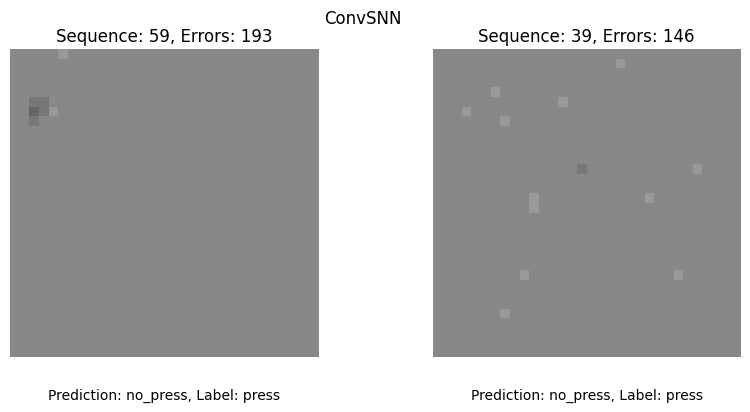

In [18]:
visualize_top_errors(model, test_dataloader, model_name="ConvSNN", top_n=5, save_path='convsnn_top_errors4.mp4')

[(59, 82), (39, 64)]
[(16, 261), (24, 161), (22, 124), (12, 117), (11, 112), (89, 108), (13, 107), (0, 104), (90, 92), (18, 88), (59, 82), (78, 80), (96, 69), (38, 68), (39, 64), (68, 59), (82, 57), (75, 56), (107, 53), (92, 49), (37, 46), (23, 44), (53, 41), (72, 39), (103, 37), (42, 36), (74, 36), (36, 35), (3, 32), (100, 31), (33, 29), (69, 28), (45, 24), (6, 22), (32, 19), (83, 19), (86, 19), (60, 18), (5, 17), (43, 17), (30, 15), (48, 15), (4, 14), (29, 12), (109, 12), (15, 11), (62, 11), (108, 11), (55, 10), (84, 9), (85, 9), (93, 9), (97, 9), (104, 8), (20, 7), (41, 7), (77, 6), (34, 5), (46, 5), (64, 5), (28, 4), (51, 4), (73, 4), (7, 3), (1, 1), (63, 1), (2, 0), (8, 0), (9, 0), (10, 0), (14, 0), (17, 0), (19, 0), (21, 0), (25, 0), (26, 0), (27, 0), (31, 0), (35, 0), (40, 0), (44, 0), (47, 0), (49, 0), (50, 0), (52, 0), (54, 0), (56, 0), (57, 0), (58, 0), (61, 0), (65, 0), (66, 0), (67, 0), (70, 0), (71, 0), (76, 0), (79, 0), (80, 0), (81, 0), (87, 0), (88, 0), (91, 0), (94, 0)

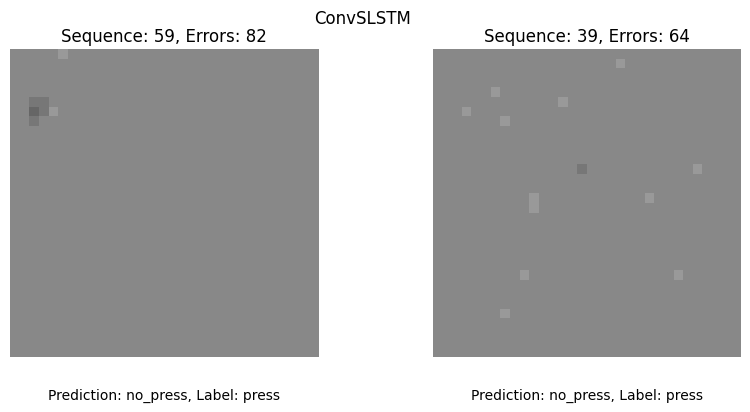

In [23]:
visualize_top_errors(model2, test_dataloader, model_name="ConvSLSTM", top_n=2, save_path='convslstm_top_errors4.mp4')

In [10]:
for i in range(len(test_dataloader.dataset)):
    print(f"seq {i}: {test_dataloader.dataset[i][1].sum()}")


seq 0: 0
seq 1: 279
seq 2: 0
seq 3: 47
seq 4: 172
seq 5: 147
seq 6: 56
seq 7: 0
seq 8: 0
seq 9: 0
seq 10: 0
seq 11: 205
seq 12: 0
seq 13: 175
seq 14: 0
seq 15: 0
seq 16: 261
seq 17: 0
seq 18: 208
seq 19: 0
seq 20: 274
seq 21: 0
seq 22: 157
seq 23: 65
seq 24: 189
seq 25: 0
seq 26: 0
seq 27: 0
seq 28: 260
seq 29: 165
seq 30: 134
seq 31: 0
seq 32: 137
seq 33: 135
seq 34: 124
seq 35: 0
seq 36: 270
seq 37: 42
seq 38: 238
seq 39: 280
seq 40: 0
seq 41: 136
seq 42: 212
seq 43: 71
seq 44: 0
seq 45: 158
seq 46: 170
seq 47: 0
seq 48: 220
seq 49: 0
seq 50: 0
seq 51: 0
seq 52: 0
seq 53: 112
seq 54: 0
seq 55: 133
seq 56: 0
seq 57: 0
seq 58: 0
seq 59: 234
seq 60: 118
seq 61: 0
seq 62: 89
seq 63: 0
seq 64: 179
seq 65: 0
seq 66: 0
seq 67: 0
seq 68: 139
seq 69: 110
seq 70: 0
seq 71: 0
seq 72: 82
seq 73: 0
seq 74: 150
seq 75: 0
seq 76: 0
seq 77: 242
seq 78: 81
seq 79: 0
seq 80: 0
seq 81: 0
seq 82: 51
seq 83: 0
seq 84: 231
seq 85: 0
seq 86: 152
seq 87: 0
seq 88: 0
seq 89: 180
seq 90: 54
seq 91: 0
seq 92: 